In [ ]:
!jupyter nbconvert --to markdown 9_7_4_Exercises.ipynb

In [1]:
import sys
import torch.nn as nn
import torch
import warnings
from sklearn.model_selection import ParameterGrid
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")

/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/d2l.py:129: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self, 'net'), 'Neural network is defined'
/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/d2l.py:133: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self, 'trainer'), 'trainer is not inited'


# 1. Adjust the hyperparameters and analyze their influence on running time, perplexity, and the output sequence.

In [2]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)
    
def stat_val(model, data):
    ppls = []
    for batch in iter(data.get_dataloader(False)):
        ppls.append(model.validation_step(batch, plot_flag=False).detach().numpy())
    return np.exp(np.mean(ppls))

def experient(data_class=d2l.TimeMachine, num_steps=32, num_hiddens=32, lr=1):
    data = data_class(batch_size=1024, num_steps=num_steps)
    lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=num_hiddens)
    model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=lr)
    trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1) #, num_gpus=1
    trainer.fit(model, data)
    return stat_val(model, data)

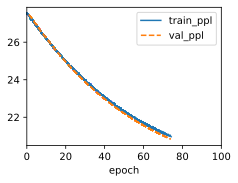

In [ ]:
param_grid = {'num_steps':[8, 16, 32, 64, 128],
              'num_hiddens':[8, 16, 32, 64, 128],
              'lr':[0.01,0.1,1,10]}
param_grid_obj = ParameterGrid(param_grid)
ppls = []
for params in param_grid_obj:
    ppl = experient(**params)
    ppls.append(ppl)
    print(params, ppl)

# 2. How would you need to change the model to generate proper words rather than just sequences of characters?

In [ ]:
class WordTimeMachine(d2l.TimeMachine): 
    def _tokenize(self, text):
        return text.split(' ')

In [ ]:
experient(data_class=WordTimeMachine)

# 3. Compare the computational cost for GRUs, LSTMs, and regular RNNs for a given hidden dimension. Pay special attention to the training and inference cost.

# 4. Since the candidate memory cell ensures that the value range is between -1 and 1 by using the tanh function, why does the hidden state need to use the tanh function again to ensure that the output value range is between -1 and 1?

# 5. Implement an LSTM model for time series prediction rather than character sequence prediction.

In [ ]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4, randn=0.2):
        self.save_hyperparameters()
        self.time = torch.range(1, T, dtype=torch.float32)
        self.x = torch.sin(0.01*self.time) + torch.randn(T)*randn
        
    def get_dataloader(self, train):
        features = [self.x[i:self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)
    
class RNNAutoRegression(d2l.LinearRegression):  #@save
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(1)

    # def output_layer(self, hiddens):
    #     return self.linear(hiddens).swapaxes(0, 1)
    
    def __init__(self, rnn,lr=0.01, tau=4, plot_flag=True, emb_len=8):
        super().__init__(lr=lr)
        self.save_hyperparameters()
        self.init_params()   

    def forward(self, X, state=None):
        rnn_outputs, _ = self.rnn(X, state)
        return self.linear(rnn_outputs)
        # return rnn_outputs

In [ ]:
tau=4
data = Data(tau=tau)
lstm = LSTM(num_inputs=tau, num_hiddens=8)
model = RNNAutoRegression(rnn=lstm, lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

In [ ]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))